(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


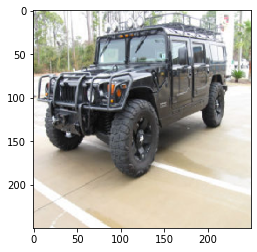

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 250, 250, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 250, 250, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 125, 125, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
12/12 [==============================] - 16s 1s/step - loss: 3.8460 - accuracy: 0.0604 - val_loss: 4.5063 - val_accuracy: 0.0791
Epoch 2/40
12/12 [==============================] - 15s 1s/step - loss: 3.1066 - accuracy: 0.1468 - val_loss: 2.6694 - val_accuracy: 0.2347
Epoch 3/40
12/12 [==============================] - 15s 1s/step - loss: 2.4797 - accuracy: 0.3011 - val_loss: 2.7034 - val_accuracy: 0.2921
Epoch 4/40
12/12 [==============================] - 15s 1s/step - loss: 2.1227 - accuracy: 0.3496 - val_loss: 2.5108 - val_accuracy: 0.3163
Epoch 5/40
12/12 [==============================] - 15s 1s/step - loss: 1.9094 - accuracy: 0.4782 - val_loss: 2.2587 - val_accuracy: 0.3673
Epoch 6/40
12/12 [==============================] - 15s 1s/step - loss: 1.7655 - accuracy: 0.5142 - val_loss: 2.8289 - val_accuracy: 0.2411
Epoch 7/40
12/12 [==============================] - 15s 1s/step - loss: 1.6422 - accuracy: 0.5403 - val_loss: 2.2513 - val_accuracy: 0.3724
Epoch 8/40
12/12 [==

In [ ]:
# -*- coding: utf-8 -*-


from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD,Adam
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications.vgg16 import VGG16
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator



batch_size = 64
num_classes = 20
epochs = 40



#### LOAD AND TRANSFORM

## Download: ONLY ONCE!
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')
#####


# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()


## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255


## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

###########################################################


############################################################

datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

## DEF CNN TOPOLOGY - VGG16
model1 = VGG16(include_top=True,weights='imagenet', input_tensor=Input(shape=x_train.shape[1:]))

#############################
###      BILINEAR        ####
#############################

def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,31*31)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt)								              # Apply l2 normalization
  return z_l2
#congelar los pesos de las conv
for layer in model1.layers:
  layer.trainable  = False



conv=model1.get_layer('block4_conv3')
d1=Dropout(0.5)(conv.output)   
d2=Dropout(0.5)(conv.output)  

x = Lambda(outer_product, name='outer_product')([d1,d2])

predictions=Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=model1.input, outputs=predictions)
opt = Adam(lr=0.1, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
  
model.summary()



## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
12/12 [==============================] - 20s 2s/step - loss: 0.1676 - accuracy: 0.9896 - val_loss: 1.2726 - val_accuracy: 0.6263
Epoch 2/40
12/12 [==============================] - 20s 2s/step - loss: 0.1312 - accuracy: 0.9936 - val_loss: 1.2756 - val_accuracy: 0.6365
Epoch 3/40
12/12 [==============================] - 20s 2s/step - loss: 0.1164 - accuracy: 0.9945 - val_loss: 1.2649 - val_accuracy: 0.6339
Epoch 4/40
12/12 [==============================] - 20s 2s/step - loss: 0.1085 - accuracy: 0.9918 - val_loss: 1.2844 - val_accuracy: 0.6454
Epoch 5/40
12/12 [==============================] - 19s 2s/step - loss: 0.0994 - accuracy: 0.9905 - val_loss: 1.3005 - val_accuracy: 0.6365
Epoch 6/40
12/12 [==============================] - 20s 2s/step - loss: 0.0932 - accuracy: 0.9952 - val_loss: 1.2698 - val_accuracy: 0.6339
Epoch 7/40
12/12 [==============================] - 20s 2s/step - loss: 0.0843 - accuracy: 0.9924 - val_loss: 1.2691 - val_accuracy: 0.6403
Epoch 8/40
12/12 [==

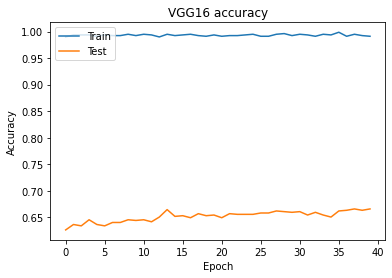

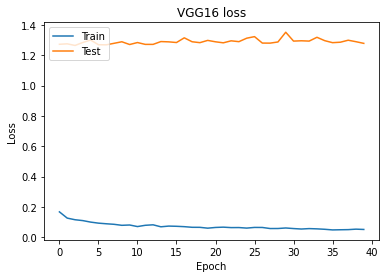

In [ ]:
#Unfreeze convolutional weights
for layer in model.layers:
  layer.trainable  = True
opt = SGD(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            verbose=1)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()